In [1]:
%pip install pandas
%pip install xlrd
%pip install category-encoders
%pip install imblearn
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the 

In [2]:
import pandas
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from category_encoders import BinaryEncoder
from imblearn.over_sampling import ADASYN
from collections import Counter

# Task 1: Data Loading and Exploration

In [3]:
data = pandas.read_excel("/Users/borisgans/Downloads/titanic3.xls")
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
# Useful for numerical data. As we can see, pclass is already ordinally encoded (min of 1 max of 3)
print(data.describe())

print(f"\nColumns: {data.columns}")

# This is great for distinguishing between the categorical and numerical variables
print(f"\nData types:\n {data.dtypes}")

            pclass     survived          age        sibsp        parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean      2.294882     0.381971    29.881135     0.498854     0.385027   
std       0.837836     0.486055    14.413500     1.041658     0.865560   
min       1.000000     0.000000     0.166700     0.000000     0.000000   
25%       2.000000     0.000000    21.000000     0.000000     0.000000   
50%       3.000000     0.000000    28.000000     0.000000     0.000000   
75%       3.000000     1.000000    39.000000     1.000000     0.000000   
max       3.000000     1.000000    80.000000     8.000000     9.000000   

              fare        body  
count  1308.000000  121.000000  
mean     33.295479  160.809917  
std      51.758668   97.696922  
min       0.000000    1.000000  
25%       7.895800   72.000000  
50%      14.454200  155.000000  
75%      31.275000  256.000000  
max     512.329200  328.000000  

Columns: Index(['pclass', 'survived

Now I'm gonna create some plots to visualize relationships between survival and: passenger class, gender, and age. 

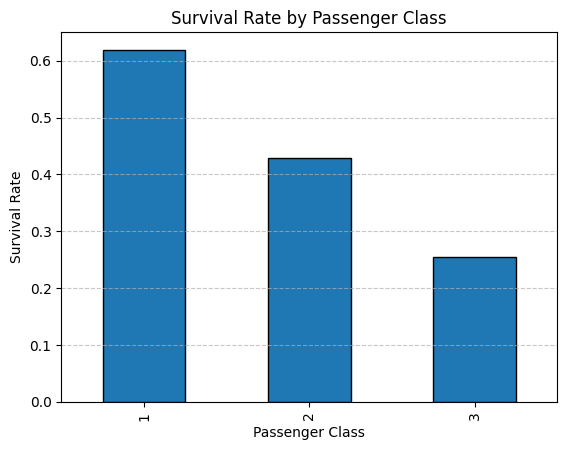

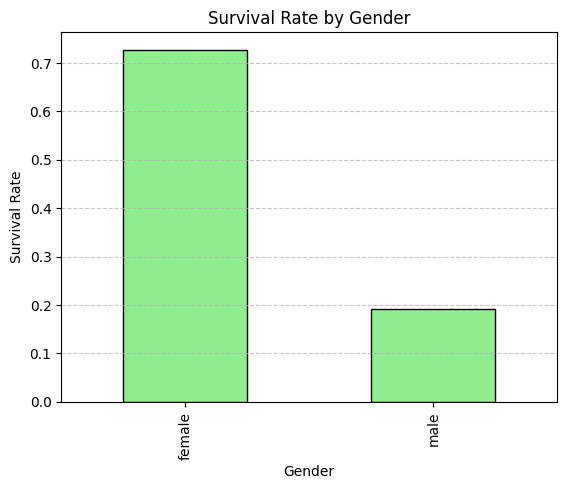

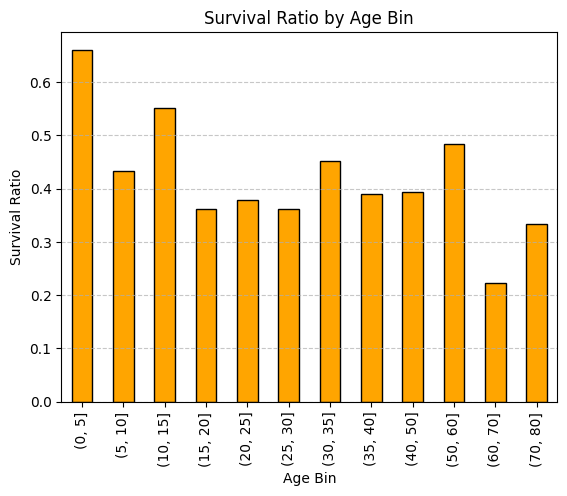

In [5]:
#Survival rate vs passenger class
survival_by_class = data.groupby('pclass')['survived'].mean()
survival_by_class.plot(kind='bar', edgecolor='black')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Survival rate vs gender
survival_by_sex = data.groupby('sex')['survived'].mean()
survival_by_sex.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Survival rate vs age
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
data['age_bin'] = pandas.cut(data['age'], bins=age_bins)
survival_by_age_bin = data.groupby('age_bin')['survived'].mean()
survival_by_age_bin.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Survival Ratio by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Survival Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Task 2: Managing Missing Values

In [6]:
data.drop(columns=['age_bin'], inplace=True)
# getting rid of column i used for plot in previous cell

pre_split_data = data.copy()
pre_split_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Data.info() shows the count of non-null entries per column. Here we can see that:
>- Age is missing 263 values
>- Fare is missing 1 value
>- Cabin is missing 1014 values
>- Embarked is missing two values
>- Boat is missing 823 values
>- Body is missing 1188 values
>- Home Destination is missing 564 values

At first, I imputed missing values before splitting my dataset into train, test, and validation sets. This is a very common and obvious way to encounter data leakage, because the values I'd impute (through staticial methods) would be the same in all 3 sets. So any patterns / relationships my model might establish from the training set will inherintly also be present in the test and validation sets. This means that some of the data in these two sets won't actually be new to the model and the performance statstics will be overly optimistic.

Instead, I can only use non-statical methods to manage missing values before splitting the dataset, meaning deleting columns and assinging constants to unknown values. I will only do this to categorical variables, as the value of 'Unknown' should have some sort of meaning and I've also found that its best practice because I may forget to impute these values later.
>- I will delete the cabin column, as it only has 295 values and in my opinion has little predictive power.
>- I will delete the body column, as it also has very few values and in my opinion it has little predicitve power.
>- I will fill in all missing values in the home.dest and embarked columns with 'Unknown'
>- For now, I will fill in all missing values in the boat column with 'Unknown', but I imagine its highly correlated with our target feature so it will probably end up being removed during feature selection.

<br>

Once I have my train set, I will address the missing values in the age and fare columns. To do so I will have to analyze their distribution to see which metric is best suited to impute into their missing values.

In [7]:
# Deleting cabin and body columns
pre_split_data.drop(columns=['cabin', 'body'], inplace=True)

# Assinging 'unknown' to missing values in the home.dest, embarked, and boat columns
pre_split_data.fillna({'home.dest': 'unknown', 'embarked': 'unknown', 'boat': 'unknown'}, inplace=True)

pre_split_data.info() #confirming its right


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   embarked   1309 non-null   object 
 10  boat       1309 non-null   object 
 11  home.dest  1309 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


Before I split the dataset and impute missing values, I will encode all applicable categorical variables using One-hot encoding. This only includes the 'Sex' and 'Embarked' columns. Pclass is already encoded in an ordered manner (1 - 3) so I don't need to worry about it, otherwise I would use Ordinal encoding for this.

In [8]:
pre_split_data = pandas.get_dummies(pre_split_data, columns=['sex'], drop_first=True)
pre_split_data = pandas.get_dummies(pre_split_data, columns=['embarked'], drop_first=True)
pre_split_data.head(10)

,pclass,survived,name,age,sibsp,parch,ticket,fare,boat,home.dest,sex_male,embarked_Q,embarked_S,embarked_unknown
0,1,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,211.3375,2,"St Louis, MO",False,False,True,False
1,1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,151.5500,11,"Montreal, PQ / Chesterville, ON",True,False,True,False
2,1,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",False,False,True,False
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",True,False,True,False
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",False,False,True,False
5,1,1,"Anderson, Mr. Harry",48.0000,0,0,19952,26.5500,3,"New York, NY",True,False,True,False
6,1,1,"Andrews, Miss. Kornelia Theodosia",63.0000,1,0,13502,77.9583,10,"Hudson, NY",False,False,True,False
7,1,0,"Andrews, Mr. Thomas Jr",39.0000,0,0,112050,0.0000,unknown,"Belfast, NI",True,False,True,False
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",53.0000,2,0,11769,51.4792,D,"Bayside, Queens, NY",False,False,True,False
9,1,0,"Artagaveytia, Mr. Ramon",71.0000,0,0,PC 17609,49.5042,unknown,"Montevideo, Uruguay",True,False,False,False


# Task 5: Splitting the dataset

First, I will just split the dataset into 'traing' and 'others' to ensure the training set is large enough. Then I split the 'others' datset into 'test' and 'validation', ensuring both are the same size.

By using stratification, I ensure that each set has the same proportion of 'survived' values as the original dataset.

Training set: 916 samples
Validation set: 196 samples
Test set: 197 samples


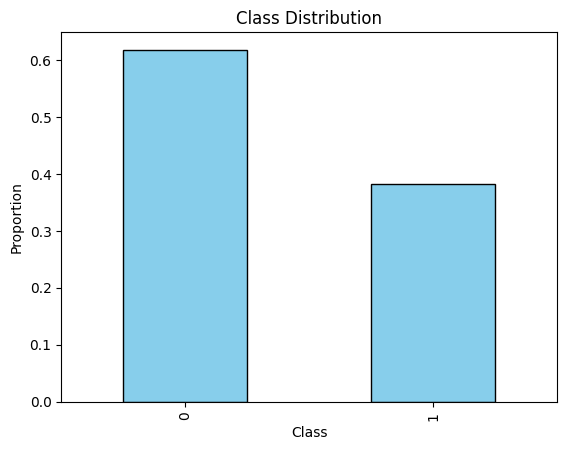

In [9]:
target_column = pre_split_data['survived']
other_columns = pre_split_data.drop(columns='survived')

# Both test_size and random_state are essentially arbitrary. 
    # 30/70 split between train and others is on the higher end (based on my limited knowledge), but it just ensures that the model has ample data to learn from
    # Random state of 42 is essentially meaningless, but I think it just acts as the seed for the randomization. This should stay the same for all splits (when splitting others)
main_train, main_other, target_train, target_other = train_test_split(
    other_columns, target_column, test_size=0.3, random_state=42, stratify=target_column
)

main_validation, main_test, target_validation, target_test = train_test_split(
    main_other, target_other, test_size=0.5, random_state=42, stratify=target_other
)
# By stratifying target value (survived) in both splits, the main and other sets have the same proportion of survived passengers 
# and the validation and test sets have the same proportion of survived passengers

print(f"Training set: {len(main_train)} samples")
print(f"Validation set: {len(main_validation)} samples")
print(f"Test set: {len(main_test)} samples")

target_train.value_counts(normalize=True).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

As we can see in the above graph, there are way more people that died than survived in our test set. This is a problem when training a model, as it'll lead to predictions biased towards not surviving. If the model predicted that everyone didn't survive it will still have an accuracy of ~60%.

To address this, we need to fix this class imbalance through resampling: either oversampling (more survivors) or undersampling (less deceased). First, however, we should impute the missing values and finish encoding the categorical variables. Also, we will need to scale our features first.

Since we used stratification when splitting, this imbalance is also present in our test and validation sets. However these should remain unchanged, as they should represent real-world data (not 50-50)

# Finishing Task 2: Managing Missing Values


To summarize, our dataset is still missing numerical values in the age column and in the fare column. Since we deleted the cabin and body columns, these missing values are no longer a concern. 

Embarked, home destination and boat also have missing values, but I already assinged a value of 'Unknown' to these so now I just need to encode these columns.

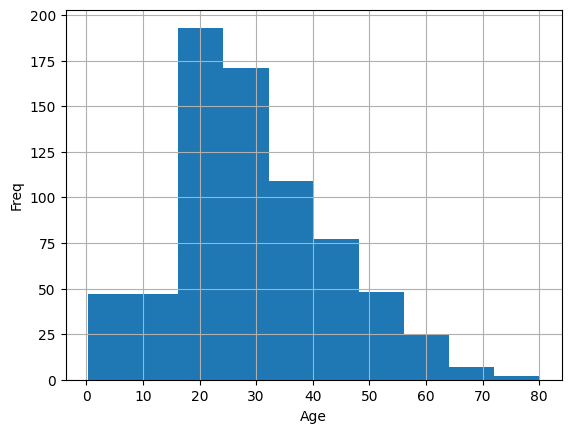

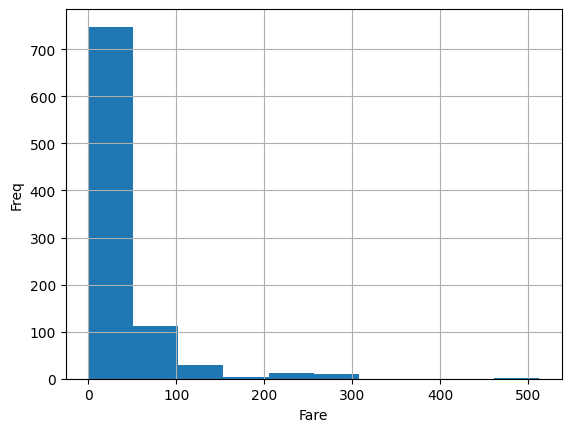

In [10]:
# main_train.info()
main_train['age'].hist()
plt.xlabel('Age')
plt.ylabel('Freq')
plt.show()

main_train['fare'].hist()
plt.xlabel('Fare')
plt.ylabel('Freq')
plt.show()


In [11]:
# As you can see in the above plots, both the age and fare columns are heavily skewed. 
# This means we should use the median, rather than the mean, as the impute value.

train_age_median = main_train['age'].median()
train_fare_median = main_train['fare'].median()

main_train['age'].fillna(train_age_median, inplace=True)
main_validation['age'].fillna(train_age_median, inplace=True)
main_test['age'].fillna(train_age_median, inplace=True)

main_train['fare'].fillna(train_fare_median, inplace=True)
main_validation['fare'].fillna(train_fare_median, inplace=True)
main_test['fare'].fillna(train_fare_median, inplace=True)

main_train.info()
main_validation.info()
main_test.info()
# Confirming all vals are filled in


<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 306 to 2
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pclass            916 non-null    int64  
 1   name              916 non-null    object 
 2   age               916 non-null    float64
 3   sibsp             916 non-null    int64  
 4   parch             916 non-null    int64  
 5   ticket            916 non-null    object 
 6   fare              916 non-null    float64
 7   boat              916 non-null    object 
 8   home.dest         916 non-null    object 
 9   sex_male          916 non-null    bool   
 10  embarked_Q        916 non-null    bool   
 11  embarked_S        916 non-null    bool   
 12  embarked_unknown  916 non-null    bool   
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 75.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 1129 to 1121
Data columns (total 13 columns):
 #   Column        

# Finishing Task 3: Encoding Categorical Variables

The categorical variables to encode are the following:
>- Name
>- Ticket
>- Home destination
>- Boat

<br>

For name and ticket I'll use binary encoding, because it represents high-cardinality features while reducing its dimensionality. Since each name and ticket is near-unique accross the entire dataset, it's important to reduce the dimensionality of each as much as possible. One-hot encoding would create thousands of sparse columns leading to increased computational complexitiy and overfitting. Binary encoding strikes a balance by preserving some categorical relationships while keeping the feature space manageable.
>- One way to improve my models accuarcy is to extract the titles from peoples names (Dr. Mr. etc.) and encode this using Count encoding. I think this will probably have more predictive power.

<br>

The home destination column has 297 unique values in the training set alone, because some values have two cities in it split by a '/'. I'm deciding to just extract the first city only and then use count encoding on it. This retains a lot of the information (especially compared to converting it to just known vs unknown), while still being simple to implement.
>- As you can see with the blow print statements, extracting the first city only got rid of 39 unique values. So, I will also use binary encoding instead of count encoding, because it reduces dimensionality, avoids overfitting by ensuring rare destinations don't overpower the model, and it will handle unseen cities better in the testing and validation sets.

<br>

The boat column is going to be highly correlated with survived (as it denotes that an individual made it onto the lifeboat to begin with), so I'll convert it into a binary indicator representing whether an individual was in a boat or not. This ensures that the boat column is still only one column, even though most tickets are unique from each other. It is also the simpler approach to take, especially considering it'll likley be removed during feature selection. 

In [12]:

encoder= BinaryEncoder(cols=['name', 'ticket'])
main_train = encoder.fit_transform(main_train)
main_validation = encoder.transform(main_validation)
main_test = encoder.transform(main_test)

print(f"Unique values in home destination before extraction: {main_train['home.dest'].nunique()}")
main_train['home.dest'] = main_train['home.dest'].apply(lambda x: x.split('/')[0].strip())
main_validation['home.dest'] = main_validation['home.dest'].apply(lambda x: x.split('/')[0].strip())
main_test['home.dest'] = main_test['home.dest'].apply(lambda x: x.split('/')[0].strip())
print(f"Unique values in home destination after extraction: {main_train['home.dest'].nunique()}")

encoder = BinaryEncoder(cols=['home.dest'])
main_train = encoder.fit_transform(main_train)
main_validation = encoder.transform(main_validation)
main_test = encoder.transform(main_test)

main_train['boat'] = main_train['boat'].apply(lambda x: 0 if x == 'unknown' else 1)
main_validation['boat'] = main_validation['boat'].apply(lambda x: 0 if x == 'unknown' else 1)
main_test['boat'] = main_test['boat'].apply(lambda x: 0 if x == 'unknown' else 1)


Unique values in home destination before extraction: 297
Unique values in home destination after extraction: 258


# Task 4: Feature Scaling


By scaling our numerical features, we ensure they all have a similar range. It improves model performance by tranforming features on a common scale, making it much easier (and more accurate) to make comparisons between features.

<br>

Standardization is one method of feature scaling, and it centers data around 0 with a standard deviation of 1. This makes it less sensitive to outliers because it doesn't bind the data, it only centers it, and it preserves the distances and relationships between data points. Standarization is used when the data is normally distributed or you suspect it to have a Gaussian-like distribution, and for models assuming normality- like Logistic Regression. This is for a couple reasons:

>- Many models, including Logistic Regression, use gradient descent to optimize the loss function. Standardization makes the cost function more symmetrical and smoother, helping the gradient descent algorthim converge faster and more reliably.

>- Logistic Regression assumes a linear relationship between the input features and the log-odds of the outcome. Standardization makes the features more comparable in scale, which improves this linear relationship and thus improves the accuracy of this assumption. This is important, because the weights in models such as Logisitc Regression are interpreted as the change in log-odds for a one standard deviation increase in the feature. Since standardization enforces a S.D. of 1 across all numerical features, this makes the weights comparable accross features.

>- Furthermore, Regularization (how the model is penalized for complexity during training) techniques add a penalty term proportional to the magnitude of the weights. If features are on different scales (and therefore have different S.D.) their weights will not be comparable to the values actual affect to the model. The regularization term penalizes larger weights more, even if the feature is measured in larger units, for example. So, standarization ensures that all features contribute equally to the pentalty leading to fair regularization.

<br>

Normalization, on the other hand, rescales values to a fixed range. This ensures that the original distribution's shape is preserved and that the values are always positive and bounded (making it good for neural networks). However, this makes it sensitive to outliers, as a single outlier can greatly compress the rest of the values. It also doesn't handle negative values well. You should use normalization when you don't know the distribution of the data or when its highly skewed, and its great for distance-based models like kNN and Neural Networks. This is because:

>- Its based purley based on the min and max values of a feature, meaning it doesn't assume any specific distribution.

>- Since all data is compressed into a fixed range, outliers are compressed as well. This means the outliers don't affect the mean and S.D. of a feature's distribution, however it decreases relative distances which can lead to a loss of information for the majority of the data points.

>- By normalizing the magnitude of each features, it greatly improves the accuarcy of distance-based models (like kNN and Neural Networks). It ensures that no one feature dominates the distance metric, even though its real magnitude is much higher than other numerical features.

<br>

Since we're working with a Logistic Regression Model, which assumes normality, we should use standardization. 

In [13]:
scaler = StandardScaler()
cols_to_scale = ['age', 'sibsp', 'parch', 'fare']
scaler.fit(main_train[cols_to_scale])

main_train[cols_to_scale] = scaler.transform(main_train[cols_to_scale])
main_validation[cols_to_scale] = scaler.transform(main_validation[cols_to_scale])
main_test[cols_to_scale] = scaler.transform(main_test[cols_to_scale])

main_train.head(15)

,pclass,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,...,home.dest_3,home.dest_4,home.dest_5,home.dest_6,home.dest_7,home.dest_8,sex_male,embarked_Q,embarked_S,embarked_unknown
306,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,True,False,True,False
927,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,True,False,False,False
642,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,True,False,True,False
1294,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,True,False,True,False
1015,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,True,False,True,False
220,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,False,False,False,False
985,3,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,True,False,True,False
356,2,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,True,False,True,False
538,2,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,True,False,False,False
828,3,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,1,False,False,True,False


# Task 6: Addressing Class Imbalance

If you revisit task 5, you can see that I plotted the distriubtion of survivors vs non-survivors in my training set. I described how this is a problem when training a model, as it'll lead to predictions biased towards whichever class has the majority. If the model predicted that everyone didn't survive, it will still have an accuracy of ~60%.

I choose to use ADASYN over SMOTE, as its essentially an improved version of SMOTE. Rather than just choosing random points along the lines connecting neighbors, ADASYN adds a small amount of variance to the values making them more realistic and scattered.

In [14]:
print(f"Before resampling: {Counter(target_train)}")

sampler = ADASYN(random_state=42)
main_train_resampled, target_train_resampled = sampler.fit_resample(main_train, target_train)

print(f"After resampling: {Counter(target_train_resampled)}")

Before resampling: Counter({0: 566, 1: 350})
After resampling: Counter({0: 566, 1: 553})


# Task 7: Feature Selection

By splitting the dataset into train, validation, and test sets before balancing the classes and selecting the features we avoid data leakage, ensuring a fair evaluation of our model. 

ADASYN generates synthetic data by learning from exisitg examples in the minority class. If applied before splitting, the validation and test sets could contain synthetic samples that were generated from the test set. This means the model would be trained off data that's very similar to data already included in the validation and test sets, leading to inflated performance metrics. 

Feature selection analyzes feature relationships within the dataset. If we did this before splitting the data, it would be using information from the entire dataset to make these conclusions. We (/ our program) would have knowledge from the entire dataset, meaning our validation and test sets are no longer unseen data.

<br>

By performing feature selection, we eliminate features that don't contribute meaningful information. This reduces overfitting and improves model performance (fewer features to train on).

First, we will eliminate features with low variance.

In [15]:
selector = VarianceThreshold(threshold=0.01)
main_train_reduced = selector.fit_transform(main_train_resampled)
main_validation_reduced = selector.transform(main_validation)
main_test_reduced = selector.transform(main_test)

selected_features = main_train.columns[selector.get_support()]
print(f"Selected features: {list(selected_features)}")

main_train = pandas.DataFrame(main_train_reduced, columns=selected_features)
main_validation = pandas.DataFrame(main_validation_reduced, columns=selected_features)
main_test = pandas.DataFrame(main_test_reduced, columns=selected_features)


Selected features: ['pclass', 'name_0', 'name_1', 'name_2', 'name_3', 'name_4', 'name_5', 'name_6', 'name_7', 'name_8', 'name_9', 'age', 'sibsp', 'parch', 'ticket_0', 'ticket_1', 'ticket_2', 'ticket_3', 'ticket_4', 'ticket_5', 'ticket_6', 'ticket_7', 'ticket_8', 'ticket_9', 'fare', 'boat', 'home.dest_1', 'home.dest_2', 'home.dest_3', 'home.dest_4', 'home.dest_5', 'home.dest_6', 'home.dest_7', 'home.dest_8', 'sex_male', 'embarked_Q', 'embarked_S']


Now we need to identify highly correlated features

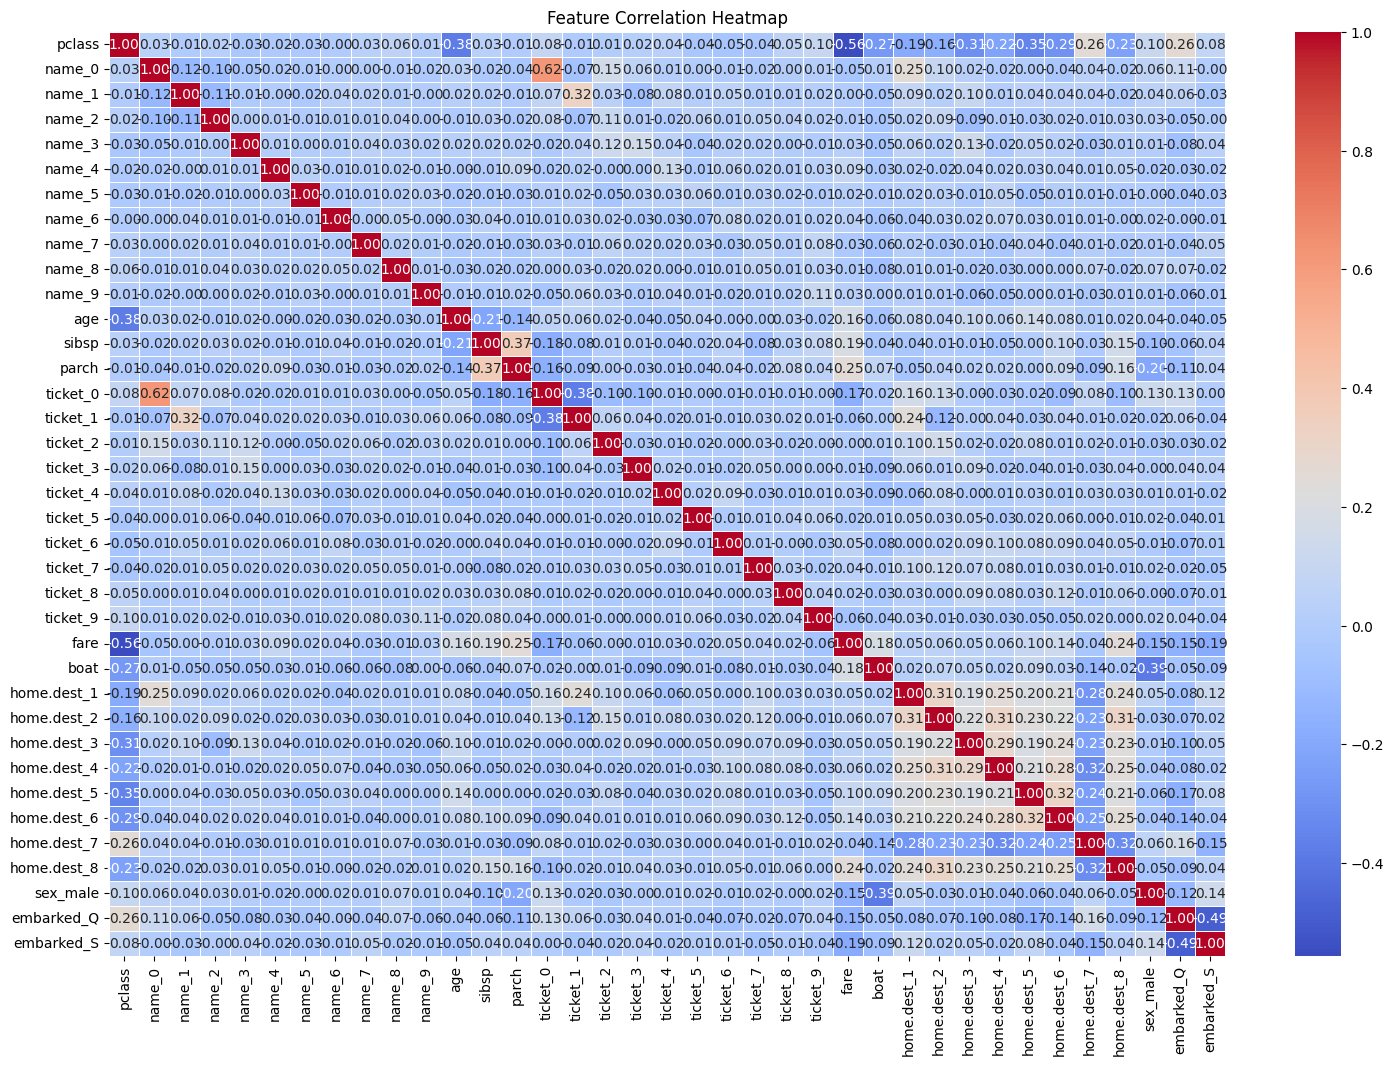

In [16]:
corr_matrix = main_train.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

From my limited knowledge, correlation thresholds tend to range between 0.8 - 0.9. Regardless, the highest correlationn value is 0.62, between ticket_0 and name_0. So I don't have any highly correlated features to remove. Now we can train the model.

# Task 8: Training a Logisitc Regression Model

### Validation Set

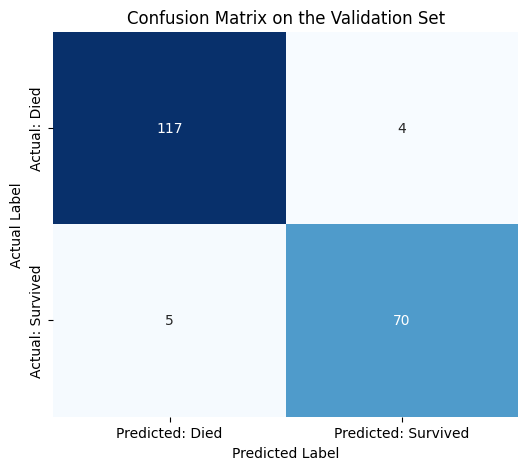

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       121
           1       0.95      0.93      0.94        75

    accuracy                           0.95       196
   macro avg       0.95      0.95      0.95       196
weighted avg       0.95      0.95      0.95       196



In [17]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(main_train, target_train_resampled)

target_pred = model.predict(main_validation)
cm = confusion_matrix(target_validation, target_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Died', 'Predicted: Survived'],
            yticklabels=['Actual: Died', 'Actual: Survived'])
plt.title('Confusion Matrix on the Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print(classification_report(target_validation, target_pred))

### Test Set

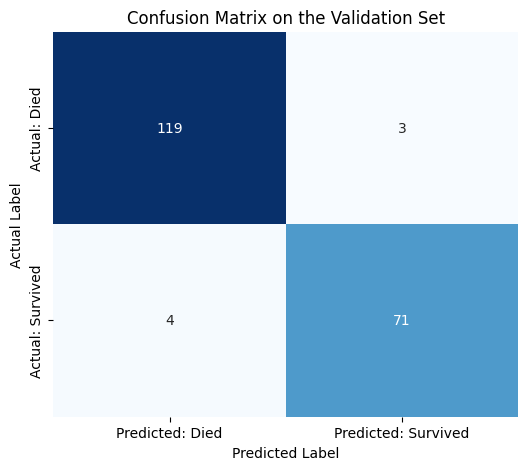

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       122
           1       0.96      0.95      0.95        75

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



In [19]:
target_pred_test = model.predict(main_test)
cm = confusion_matrix(target_test, target_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Died', 'Predicted: Survived'],
            yticklabels=['Actual: Died', 'Actual: Survived'])
plt.title('Confusion Matrix on the Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print(classification_report(target_test, target_pred_test))


As you can see, the model performed quite well with an accuracy of 95% on the validation set and 96% on the test set. The confusion matrix allows you to visualize this accuarcy, with only 5 false negatives and 4 false positives.